In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pyuvdata import UVData

In [2]:
import scipy

In [3]:
import copy

In [4]:
import time

In [5]:
class uvdata_pol_calibrator():
    
    def __init__(self, model_data=None, real_data=None, mode="model_based"):
        """
        Parameters
        ----------
        model_data, real_data : UVData
        
        mode : str
            Specify the way gains are aligned. Choices are "model_based" and "data_based".
            "model_based" means V_ij_data = G_i V_ij_model G_j^H,
            and "data_based" means V_ij_model = G_i V_ij_data G_j^H.
            
        """
        if mode == "model_based":
            self.base_data, self.prod_data = model_data, real_data
        if mode == "data_based":
            self.base_data, self.prod_data = real_data, model_data
        self.gain_array = np.zeros((self.base_data.Nants_data, self.base_data.Nfreqs, 2, 2)).astype(np.complex128)
        self.gain_H_array = np.zeros((self.base_data.Nants_data,self.base_data.Nfreqs, 2, 2)).astype(np.complex128)
        
    def data_slice(self, use_all_times=False, base_time_range=[], prod_time_range=[], use_all_frequencies=False, base_freq_range=[], prod_freq_range=[], 
                   use_all_ants=False, base_ants=[], prod_ants=[]):
        """
        Get a slice of the data.
        
        Parameters
        ----------

       


        """
        if use_all_ants:
            ants = np.unique(self.prod_data.ant_1_array)
        else:
            assert isinstance(base_ants, list) and isinstance(prod_ants, list), "ants must be a list." 
            base_ants, prod_ants= list(np.sort(base_ants)), list(np.sort(prod_ants))
            assert base_ants == prod_ants
            ants = prod_ants
        self.ants2cal = ants
        
        if use_all_times:
            base_time_range = [np.unique(self.base_data.time_array)[0]-1e-2, np.unique(self.base_data.time_array)[-1]+1e-2]
            prod_time_range = [np.unique(self.prod_data.time_array)[0]-1e-2, np.unique(self.prod_data.time_array)[-1]+1e-2]
        else:
            assert isinstance(base_time_range, list) and isinstance(prod_time_range, list), "time_range must be a list"
            assert len(base_time_range) == len(prod_time_range), "Length of time_ranges must be the same."
            assert len(base_time_range) == 2, "Length of time_range must be 2."
        
        if use_all_frequencies:
            base_freqs = list(range(self.base_data.Nfreqs))
            prod_freqs = list(range(self.prod_data.Nfreqs))
        else:
            assert isinstance(base_freq_range, list) and isinstance(prod_freq_range, list), "freq_range must be a list"
            assert base_freq_range == prod_freq_range, "freq_ranges must be the same."
            if len(base_freq_range) == 1:
                base_freqs = base_freq_range
                prod_freqs = prod_freq_range
            elif len(base_freq_range) == 2:
                base_freqs = list(range(base_freq_range[0],base_freq_range[1]+1))
                prod_freqs = list(range(prod_freq_range[0],prod_freq_range[1]+1))
            else:
                raise ValueError("Length of freq_range must be 1 or 2.")
        self.freqs2cal = prod_freqs
        
        base_data_slice = self.base_data.select(antenna_nums=ants, freq_chans=base_freqs, time_range=base_time_range, inplace=False) 
        prod_data_slice = self.prod_data.select(antenna_nums=ants, freq_chans=prod_freqs, time_range=prod_time_range, inplace=False)             
        
        # original data_array shape: (Nblts, Nspws, Nfreqs, )
        # intermidiate data_array shape: (Nants, Nants, Nspws, Ntimes, Nfreqs, Npols)
        # final data_array shape: (Nants, Nants, :, 2, 2)
        assert base_data_slice.data_array.shape == prod_data_slice.data_array.shape
        base_data_array = np.zeros((len(ants), len(ants), base_data_slice.Nspws, base_data_slice.Ntimes, base_data_slice.Nfreqs, base_data_slice.Npols)).astype(np.complex128)
        prod_data_array = np.zeros((len(ants), len(ants), prod_data_slice.Nspws, prod_data_slice.Ntimes, prod_data_slice.Nfreqs, prod_data_slice.Npols)).astype(np.complex128)
        
        for (i, ant1) in enumerate(ants):
            for (j,ant2) in enumerate(ants):
                for spw in range(base_data_slice.Nspws): 
                    if ant1 <= ant2:
                        baseline_number = 2048*(ant1+1)+(ant2+1)+2**16
                        # baseline index = 2048 * (ant1+1) + (ant2+1) + 2**16
                        base_data_array_copy = base_data_slice.get_data(baseline_number)
                        # uvdata.get_data() returns an array with a shape (Ntimes, Nfreqs, Npols) 
                        base_data_array[i,j,spw, :,:,0], base_data_array[i,j,spw, :,:,1],  base_data_array[i,j,spw, :,:,2],  base_data_array[i,j,spw, :,:,3] = base_data_array_copy[:,:,0], base_data_array_copy[:,:,2],  base_data_array_copy[:,:,3],  base_data_array_copy[:,:,1]
                        """
                        data_array orginally stores the polarization information as a 1d array [-5, -6, -7, -8], corresponding to [XX, YY, XY, YX].
                        Here we first modify it into [-5,-7, -8,-6], 
                        then we will modify it into a 2d array[[-5,-7],[-8,-6]], corresponding to [[XX, XY], [YX, YY]].
                        """
                        prod_data_array_copy = prod_data_slice.get_data(baseline_number)
                        prod_data_array[i,j,spw, :,:,0], prod_data_array[i,j,spw, :,:,1], prod_data_array[i,j,spw, :,:,2], prod_data_array[i,j,spw, :,:,3] = prod_data_array_copy[:,:,0], prod_data_array_copy[:,:,2], prod_data_array_copy[:,:,3], prod_data_array_copy[:,:,1]

                    if ant1 > ant2:
                        baseline_number = 2048*(ant2+1)+(ant1+1)+2**16
                        base_data_array_copy = np.conj(base_data_slice.get_data(baseline_number))
                        base_data_array[i,j,spw, :,:,0], base_data_array[i,j,spw, :,:,1],  base_data_array[i,j,spw, :,:,2],  base_data_array[i,j,spw, :,:,3] = base_data_array_copy[:,:,0], base_data_array_copy[:,:,3], base_data_array_copy[:,:,2], base_data_array_copy[:,:,1]
                        """
                        Since V_{ji} = V_{ij}^H, we should take conjugate values here and then reorder the pols as
                        [-5,-8, -7,-6], which becomes [[-5,-8],[-7,-6]] after converted into a 2d array.
                        """
                        prod_data_array_copy = np.conj(prod_data_slice.get_data(baseline_number))
                        prod_data_array[i,j,spw, :,:,0], prod_data_array[i,j,spw, :,:,1], prod_data_array[i,j,spw, :,:,2], prod_data_array[i,j,spw, :,:,3] = prod_data_array_copy[:,:,0], prod_data_array_copy[:,:,3], prod_data_array_copy[:,:,2], prod_data_array_copy[:,:,1]


        data_shape = base_data_array.shape
        base_data_array = base_data_array.reshape((data_shape[0], data_shape[1], data_shape[2], data_shape[3], data_shape[4], 2, 2))
        prod_data_array = prod_data_array.reshape((data_shape[0], data_shape[1], data_shape[2], data_shape[3], data_shape[4], 2, 2))
        # reshape the pols
        base_data_array = base_data_array.reshape((data_shape[0], data_shape[1], data_shape[2]*data_shape[3]*data_shape[4], 2, 2))
        prod_data_array = prod_data_array.reshape((data_shape[0], data_shape[1], data_shape[2]*data_shape[3]*data_shape[4], 2, 2))
        # concatenate axis to a shape (Nants, Nants, :, 2, 2)

        self.base_data_array,  self.prod_data_array = base_data_array, prod_data_array
        
    def Wirtinger_lm_cal(self, diagonalize=False, Niteration=50, including_autobaseline=False, verbose=False):
        """
        Using Newton-Gauss method to obtain calibration gains G which minimizing \sum{D_[ij]-G_i M_{ij} G_j^H}, where D, G and M are all 2*2 matrices. 
        Update each step: G_{k+1} = [J(G_k)^H J(G_k)]^{-1} * J(G_k)^H * D, where J is the Jacobian matrix. 

        Parameters
        ----------

       

        Returns
        -------

        gain : dict
            calibration gains

        residual : 

        """
        ants, prod, base = self.ants2cal, self.prod_data_array, self.base_data_array
        gain_prev = np.array([[1,0],[0,1]]).astype(np.complex128)
        gain_prev = np.repeat(gain_prev[np.newaxis,:,:], len(ants), axis=0)
        gain_H_prev = np.copy(gain_prev)
        gain_next, gain_H_next = np.zeros_like(gain_prev), np.zeros_like(gain_prev)
        
        residual = np.zeros(Niteration)

        for iteration in range(Niteration):
            for (i,ant) in enumerate(ants):
                JH_J = np.zeros((2,2)).astype(np.complex128)
                JH_D = np.zeros((2,2)).astype(np.complex128)
                for (j,ant_q) in enumerate(ants):
                    # sum over baselines, frequencies and times
                    JH_J += np.sum(np.matmul(base[i,j], np.matmul(gain_H_prev[j][None], np.matmul(gain_prev[j][None], base[j,i]))), axis=0)
                    JH_D += np.sum(np.matmul(prod[i,j], np.matmul(gain_prev[j][None], base[j, i])), axis=0)
                if not including_autobaseline:
                    # if not including auto-baseline
                    JH_J -= np.sum(np.matmul(base[i,i], np.matmul(gain_H_prev[i][None], np.matmul(gain_prev[i][None], base[i,i]))), axis=0)
                    JH_D -= np.sum(np.matmul(prod[i,i], np.matmul(gain_prev[i][None], base[i, i])), axis=0)         
                if diagonalize==True:
                    gain_next[i] = np.diag(np.diag(np.matmul(JH_D, np.linalg.inv(JH_J))))
                else:
                    gain_next[i] = np.matmul(JH_D, np.linalg.inv(JH_J))
                
                JH_J = np.zeros((2,2)).astype(np.complex128)
                JH_D = np.zeros((2,2)).astype(np.complex128)
                for (k,ant_p) in enumerate(ants):
                    JH_J += np.sum(np.matmul(base[i,k], np.matmul(gain_H_prev[k][None], np.matmul(gain_prev[k][None], base[k,i]))), axis=0)
                    JH_D += np.sum(np.matmul(base[i,k], np.matmul(gain_H_prev[k][None], prod[k, i])), axis=0)     
                if not including_autobaseline:
                    JH_J -= np.sum(np.matmul(base[i,i], np.matmul(gain_H_prev[i][None], np.matmul(gain_prev[i][None], base[i,i]))), axis=0)
                    JH_D -= np.sum(np.matmul(base[i,i], np.matmul(gain_H_prev[i][None], prod[i, i])), axis=0)  
                if diagonalize==True:
                    gain_H_next[i] = np.diag(np.diag(np.matmul(np.linalg.inv(JH_J), JH_D)))
                else:
                    gain_H_next[i] = np.matmul(np.linalg.inv(JH_J), JH_D)
            
            # Rephase to one antenna feed to reduce the degeneracies
            gain_prev = gain_next*np.exp(-1.j*np.angle(gain_next[0,0,0]))
            gain_H_prev = gain_H_next*np.exp(1.j*np.angle(gain_next[0,0,0]))

            for ant in range(len(ants)):
                for ant_r in range(len(ants)):
                    if including_autobaseline:
                         residual[iteration] += np.linalg.norm(prod[ant,ant_r] - np.matmul(gain_prev[ant][None], np.matmul(base[ant,ant_r], gain_H_prev[ant_r][None])))
                    else:
                        if ant_r != ant:
                            residual[iteration] += np.linalg.norm(prod[ant,ant_r] - np.matmul(gain_prev[ant][None], np.matmul(base[ant,ant_r], gain_H_prev[ant_r][None])))
        
        # Add results to self.gain_array
        ants_all = np.unique(self.prod_data.ant_1_array)
        for i, ant in enumerate(ants):
            ant_index = np.where(ants_all==ant)
            for freq_index in self.freqs2cal:
                self.gain_array[ant_index, freq_index,:,:] = gain_prev[i,:,:]
                self.gain_H_array[ant_index, freq_index,:,:] = gain_H_prev[i,:,:]

        if verbose:
            print(residual)                    






In [6]:
uvd_data = UVData()

In [7]:
uvd_data.read("/lustre/aoc/projects/hera/zmartino/hera_calib_model/IDR2/abscal_files_v02/zen.2458106.22659.uvh5")

Telescope mock-HERA is not in known_telescopes.


In [8]:
uvd_test = copy.deepcopy(uvd_data)

## Apply gains

reorder gain_array to ant_1_gain_array and ant_2_gain_array

In [9]:
gain_array = np.zeros((uvd_data.Nants_data, uvd_data.Nfreqs, 2, 2)).astype(np.complex128)

In [10]:
ant_dicts = dict(enumerate(np.unique(uvd_data.ant_1_array)))
ant_dicts = dict((v,k) for k,v in ant_dicts.items())

In [11]:
gain_array[:,300,0,0] += 1
gain_array[:,300,1,1] += 1

In [12]:
gain_array[:,300,:,:] += np.random.normal(0,0.1,(uvd_data.Nants_data,2,2))*np.exp(-1.j*2*np.pi*(np.random.rand(uvd_data.Nants_data,2,2)))

### rephase

In [13]:
gain_array[:,300,:,:] *= np.exp(-1.j*np.angle(gain_array[0,300,0,0]))

In [14]:
np.angle(gain_array[0,300,0,0]), np.angle(gain_array[0,300,0,1]), np.angle(gain_array[0,300,1,0]), np.angle(gain_array[0,300,1,1])

(0.0, -1.1042627011252037, -1.245202596791503, 0.028172407967515085)

In [15]:
ant_1_gain_array = []
for ant in uvd_data.ant_1_array[0:uvd_data.Nbls]:
    ant_index = ant_dicts[ant]
    ant_1_gain_array.append(gain_array[ant_index,:,:,:])
ant_1_gain_array = np.array(ant_1_gain_array)
ant_1_gain_array = ant_1_gain_array[:,None,:,:,:]
ant_1_gain_array = np.tile(ant_1_gain_array, (uvd_data.Ntimes,1,1,1,1))

In [16]:
ant_2_gain_array = []
for ant in uvd_data.ant_2_array[0:uvd_data.Nbls]:
    ant_index = ant_dicts[ant]
    ant_2_gain_array.append(gain_array[ant_index,:,:,:])
ant_2_gain_array = np.array(ant_2_gain_array)
ant_2_gain_array = ant_2_gain_array[:,None,:,:,:]
ant_2_gain_array = np.tile(ant_2_gain_array,(uvd_data.Ntimes,1,1,1,1))
ant_2_gain_array = np.conj(ant_2_gain_array)
ant_2_gain_array = np.transpose(ant_2_gain_array, (0,1,2,4,3))

In [17]:
raw_data_array = np.zeros_like(uvd_data.data_array).astype(np.complex128)

In [18]:
raw_data_array[:,:,:,0], raw_data_array[:,:,:,1],  raw_data_array[:,:,:,2],  raw_data_array[:,:,:,3] = uvd_data.data_array[:,:,:,0], uvd_data.data_array[:,:,:,2], uvd_data.data_array[:,:,:,3], uvd_data.data_array[:,:,:,1]

In [19]:
raw_data_array = raw_data_array.reshape((raw_data_array.shape[0],raw_data_array.shape[1], raw_data_array.shape[2],2,2))

In [20]:
raw_data_array.shape

(82680, 1, 1024, 2, 2)

In [21]:
ant_1_gain_array.shape

(82680, 1, 1024, 2, 2)

In [22]:
ant_2_gain_array.shape

(82680, 1, 1024, 2, 2)

In [23]:
test_data_array = np.matmul(ant_1_gain_array, np.matmul(raw_data_array, ant_2_gain_array))

In [24]:
test_data_array.shape

(82680, 1, 1024, 2, 2)

In [25]:
uvd_test.data_array[:,:,:,0], uvd_test.data_array[:,:,:,1], uvd_test.data_array[:,:,:,2], uvd_test.data_array[:,:,:,3] = test_data_array[:,:,:,0,0], test_data_array[:,:,:,1,1], test_data_array[:,:,:,0,1], test_data_array[:,:,:,1,0]

## Apply Smirnov method on single times

In [26]:
uv_polcal_sin = uvdata_pol_calibrator(model_data=uvd_data, real_data=uvd_test, mode="model_based")

In [27]:
uv_polcal_sin.data_slice(base_time_range=[2458106.226586, 2458106.22659], prod_time_range=[2458106.226586, 2458106.22659], 
                             base_freq_range=[300], prod_freq_range=[300], use_all_ants=True)

In [28]:
uv_polcal_sin.base_data_array.shape

(52, 52, 1, 2, 2)

#### check for gain broadcasting

In [29]:
uv_polcal_sin.base_data_array[3,2,0]

array([[1.75117331-1.96248438j, 0.02899844+0.02595856j],
       [0.01977597+0.05668942j, 1.36081252-1.93853531j]])

In [30]:
uv_polcal_sin.prod_data_array[3,2,0]

array([[ 1.78909247-1.73916145j,  0.22996973-0.3413049j ],
       [-0.12668758+0.37659191j,  1.7979798 -1.61000811j]])

In [31]:
np.matmul(gain_array[3,300],np.matmul(uv_polcal_sin.base_data_array[3,2,0], np.conj(np.transpose(gain_array[2,300])) ))

array([[ 1.78909247-1.73916145j,  0.22996973-0.3413049j ],
       [-0.12668758+0.37659191j,  1.7979798 -1.61000811j]])

In [32]:
gain_array_iterations = []
for iteration in [10,20,30,40,50,100,200,500,1000]:
    start_time = time.time()
    uv_polcal_sin.Wirtinger_lm_cal(diagonalize=False, Niteration=iteration)
    print("--- %s seconds ---" % (time.time() - start_time))
    print(uv_polcal_sin.gain_array[0,300])
    gain_array_iterations.append(uv_polcal_sin.gain_array[:,300])

--- 2.430919885635376 seconds ---
[[ 1.04904599+0.j         -0.00238589+0.01507421j]
 [ 0.00333115-0.05120477j  0.95536094+0.03308491j]]
--- 4.052056789398193 seconds ---
[[ 1.04903809+5.42101086e-20j -0.00236632+1.49529712e-02j]
 [ 0.00342523-5.12269644e-02j  0.95535639+3.30669954e-02j]]
--- 5.9795966148376465 seconds ---
[[ 1.04903023+0.j         -0.00234679+0.01483246j]
 [ 0.00351874-0.05124908j  0.95535186+0.03304915j]]
--- 8.193238258361816 seconds ---
[[ 1.04902243+5.42101086e-20j -0.00232733+1.47126834e-02j]
 [ 0.00361169-5.12711412e-02j  0.95534736+3.30313722e-02j]]
--- 10.166754245758057 seconds ---
[[ 1.04901467-5.42101086e-20j -0.00230792+1.45936246e-02j]
 [ 0.00370407-5.12931346e-02j  0.95534288+3.30136737e-02j]]
--- 19.679959297180176 seconds ---
[[ 1.04897661-5.42101086e-20j -0.00221169+1.40090058e-02j]
 [ 0.00415773-5.14021498e-02j  0.95532083+3.29262969e-02j]]
--- 39.3577663898468 seconds ---
[[ 1.04890402+0.j         -0.00202337+0.01289143j]
 [ 0.00502496-0.0516154j   

### compare original gains and the recovered gains

In [33]:
np.angle(gain_array[0,300,0,0])

0.0

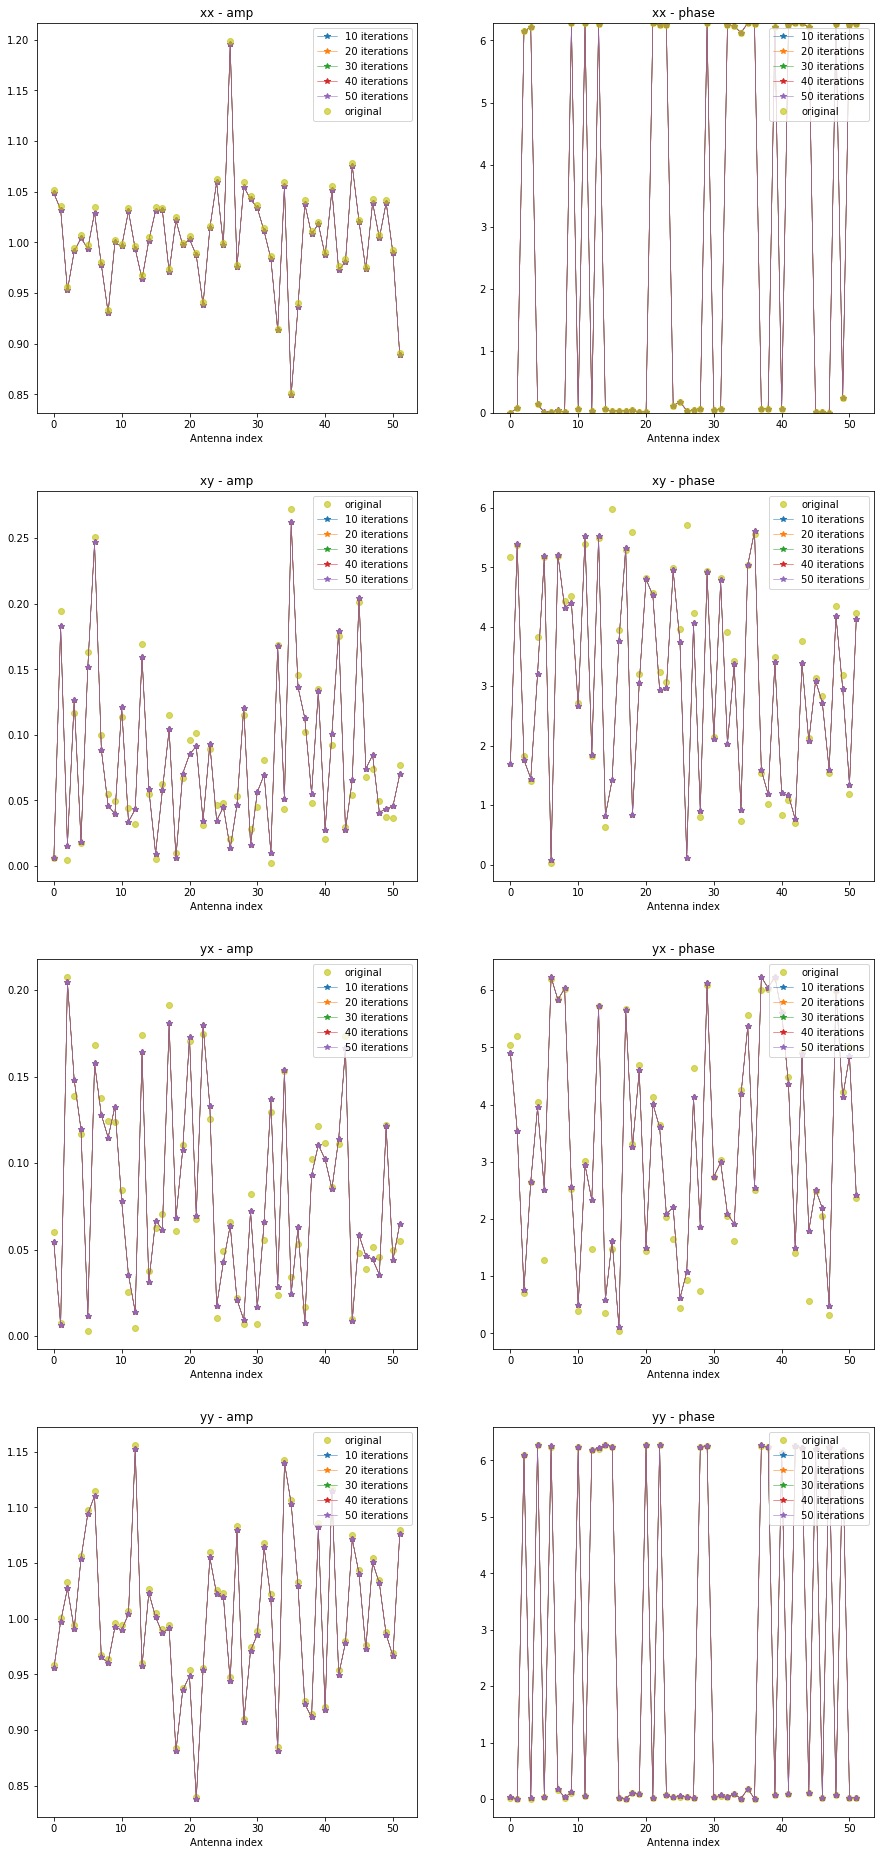

In [34]:
iterations = [10,20,30,40,50]
fig, axes = plt.subplots(figsize=(15,33), nrows=4, ncols=2)
ax = axes[0,0]
for (i,itetation) in enumerate(iterations):
    ax.plot(abs(gain_array_iterations[i][:,0,0]),'-*', label='{} iterations'.format(iterations[i]),lw=0.5)
ax.plot(abs(gain_array[:,300,0,0]),"o", label='original',lw=3, c='y',alpha=0.6)
ax.legend(loc='upper right')
ax.set_xlabel("Antenna index")
ax.set_title("xx - amp")

ax = axes[0,1]
for (i,itetation) in enumerate(iterations):
    angles_rec = np.angle(gain_array_iterations[i][:,0,0])
    angles_rec[np.where(angles_rec<0)] += 2*np.pi
    ax.plot(angles_rec,'-*', label='{} iterations'.format(iterations[i]), lw=0.5)
angles = np.angle(gain_array[:,300,0,0])
angles[np.where(angles<0)] += 2*np.pi
ax.plot(angles,'o',label='original',lw=3, c='y',alpha=0.6)
ax.set_ylim(0, np.pi*2)
ax.set_xlabel("Antenna index")
ax.set_title("xx - phase")
ax.legend(loc='upper right')

ax = axes[1,0]
ax.plot(abs(gain_array[:,300,0,1]),'o',label='original',lw=3, c='y',alpha=0.6)
for (i,itetation) in enumerate(iterations):
    ax.plot(abs(gain_array_iterations[i][:,0,1]),'-*', label='{} iterations'.format(iterations[i]),lw=0.5)
ax.set_xlabel("Antenna index")
ax.set_title("xy - amp")
ax.legend(loc='upper right')

ax = axes[1,1]
angles = np.angle(gain_array[:,300,0,1])
angles[np.where(angles<0)] += 2*np.pi
ax.plot(angles, "o", label='original', lw=3, c='y', alpha=0.6)
for (i,itetation) in enumerate(iterations):
    angles_rec = np.angle(gain_array_iterations[i][:,0,1])
    angles_rec[np.where(angles_rec<0)] += 2*np.pi
    ax.plot(angles_rec,'-*',label='{} iterations'.format(iterations[i]), lw=0.5)
ax.set_xlabel("Antenna index")
ax.set_title("xy - phase")
ax.legend(loc='upper right')

ax = axes[2,0]
ax.plot(abs(gain_array[:,300,1,0]),"o",label='original',lw=3, c='y',alpha=0.6)
for (i,itetation) in enumerate(iterations):
    ax.plot(abs(gain_array_iterations[i][:,1,0]),'-*', label='{} iterations'.format(iterations[i]),lw=0.5)
ax.set_xlabel("Antenna index")
ax.set_title("yx - amp")
ax.legend(loc='upper right')

ax = axes[2,1]
angles = np.angle(gain_array[:,300,1,0])
angles[np.where(angles<0)] += 2*np.pi
ax.plot(angles, "o", label='original',lw=3, c='y',alpha=0.6)
for (i,itetation) in enumerate(iterations):
    angles_rec = np.angle(gain_array_iterations[i][:,1,0])
    angles_rec[np.where(angles_rec<0)] += 2*np.pi
    ax.plot(angles_rec,'-*', label='{} iterations'.format(iterations[i]), lw=0.5)
ax.set_xlabel("Antenna index")
ax.set_title("yx - phase")
ax.legend(loc='upper right')

ax = axes[3,0]
ax.plot(abs(gain_array[:,300,1,1]),"o",label='original',lw=3, c='y',alpha=0.6)
for (i,itetation) in enumerate(iterations):
    ax.plot(abs(gain_array_iterations[i][:,1,1]),'-*', label='{} iterations'.format(iterations[i]),lw=0.5)
ax.set_xlabel("Antenna index")
ax.set_title("yy - amp")
ax.legend(loc='upper right')

ax = axes[3,1]
angles = np.angle(gain_array[:,300,1,1])
angles[np.where(angles<0)] += 2*np.pi
ax.plot(angles, "o", label='original',lw=3, c='y',alpha=0.6)
for (i,itetation) in enumerate(iterations):
    angles_rec = np.angle(gain_array_iterations[i][:,1,1])
    angles_rec[np.where(angles_rec<0)] += 2*np.pi
    ax.plot(angles_rec,'-*', label='{} iterations'.format(iterations[i]),lw=0.5)
ax.set_xlabel("Antenna index")
ax.set_title("yy - phase")
ax.legend(loc='upper right')

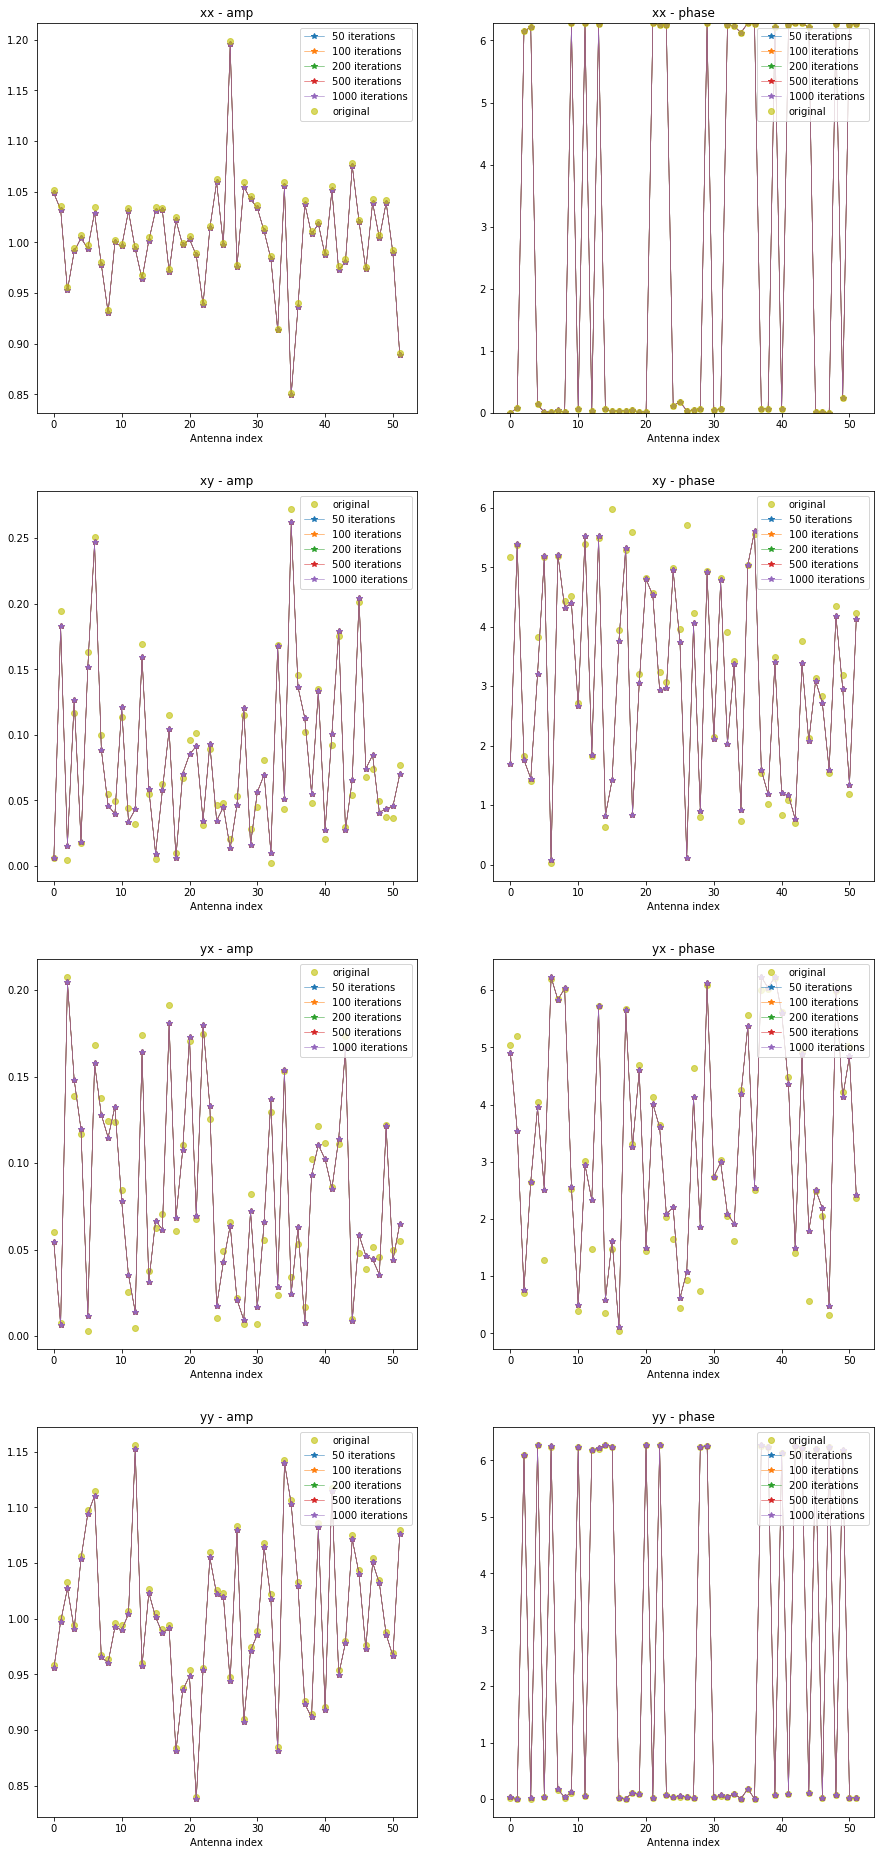

In [35]:
iterations = [50,100,200,500,1000]
fig, axes = plt.subplots(figsize=(15,33), nrows=4, ncols=2)
ax = axes[0,0]
for (i,itetation) in enumerate(iterations):
    ax.plot(abs(gain_array_iterations[i][:,0,0]),'-*', label='{} iterations'.format(iterations[i]),lw=0.5)
ax.plot(abs(gain_array[:,300,0,0]),"o", label='original',lw=3, c='y',alpha=0.6)
ax.legend(loc='upper right')
ax.set_xlabel("Antenna index")
ax.set_title("xx - amp")

ax = axes[0,1]
for (i,itetation) in enumerate(iterations):
    angles_rec = np.angle(gain_array_iterations[i][:,0,0])
    angles_rec[np.where(angles_rec<0)] += 2*np.pi
    ax.plot(angles_rec,'-*', label='{} iterations'.format(iterations[i]), lw=0.5)
angles = np.angle(gain_array[:,300,0,0])
angles[np.where(angles<0)] += 2*np.pi
ax.plot(angles,'o',label='original',lw=3, c='y',alpha=0.6)
ax.set_ylim(0, np.pi*2)
ax.set_xlabel("Antenna index")
ax.set_title("xx - phase")
ax.legend(loc='upper right')

ax = axes[1,0]
ax.plot(abs(gain_array[:,300,0,1]),'o',label='original',lw=3, c='y',alpha=0.6)
for (i,itetation) in enumerate(iterations):
    ax.plot(abs(gain_array_iterations[i][:,0,1]),'-*', label='{} iterations'.format(iterations[i]),lw=0.5)
ax.set_xlabel("Antenna index")
ax.set_title("xy - amp")
ax.legend(loc='upper right')

ax = axes[1,1]
angles = np.angle(gain_array[:,300,0,1])
angles[np.where(angles<0)] += 2*np.pi
ax.plot(angles, "o", label='original', lw=3, c='y', alpha=0.6)
for (i,itetation) in enumerate(iterations):
    angles_rec = np.angle(gain_array_iterations[i][:,0,1])
    angles_rec[np.where(angles_rec<0)] += 2*np.pi
    ax.plot(angles_rec,'-*',label='{} iterations'.format(iterations[i]), lw=0.5)
ax.set_xlabel("Antenna index")
ax.set_title("xy - phase")
ax.legend(loc='upper right')

ax = axes[2,0]
ax.plot(abs(gain_array[:,300,1,0]),"o",label='original',lw=3, c='y',alpha=0.6)
for (i,itetation) in enumerate(iterations):
    ax.plot(abs(gain_array_iterations[i][:,1,0]),'-*', label='{} iterations'.format(iterations[i]),lw=0.5)
ax.set_xlabel("Antenna index")
ax.set_title("yx - amp")
ax.legend(loc='upper right')

ax = axes[2,1]
angles = np.angle(gain_array[:,300,1,0])
angles[np.where(angles<0)] += 2*np.pi
ax.plot(angles, "o", label='original',lw=3, c='y',alpha=0.6)
for (i,itetation) in enumerate(iterations):
    angles_rec = np.angle(gain_array_iterations[i][:,1,0])
    angles_rec[np.where(angles_rec<0)] += 2*np.pi
    ax.plot(angles_rec,'-*', label='{} iterations'.format(iterations[i]), lw=0.5)
ax.set_xlabel("Antenna index")
ax.set_title("yx - phase")
ax.legend(loc='upper right')

ax = axes[3,0]
ax.plot(abs(gain_array[:,300,1,1]),"o",label='original',lw=3, c='y',alpha=0.6)
for (i,itetation) in enumerate(iterations):
    ax.plot(abs(gain_array_iterations[i][:,1,1]),'-*', label='{} iterations'.format(iterations[i]),lw=0.5)
ax.set_xlabel("Antenna index")
ax.set_title("yy - amp")
ax.legend(loc='upper right')

ax = axes[3,1]
angles = np.angle(gain_array[:,300,1,1])
angles[np.where(angles<0)] += 2*np.pi
ax.plot(angles, "o", label='original',lw=3, c='y',alpha=0.6)
for (i,itetation) in enumerate(iterations):
    angles_rec = np.angle(gain_array_iterations[i][:,1,1])
    angles_rec[np.where(angles_rec<0)] += 2*np.pi
    ax.plot(angles_rec,'-*', label='{} iterations'.format(iterations[i]),lw=0.5)
ax.set_xlabel("Antenna index")
ax.set_title("yy - phase")
ax.legend(loc='upper right')

## Apply Smirnov method on all times

In [36]:
uv_polcal_sin = uvdata_pol_calibrator(model_data=uvd_data, real_data=uvd_test, mode="model_based")

In [37]:
uv_polcal_sin.data_slice(use_all_times=True, base_freq_range=[300], prod_freq_range=[300], use_all_ants=True)

In [38]:
uv_polcal_sin.base_data_array.shape

(52, 52, 60, 2, 2)

#### check for gain broadcasting

In [39]:
uv_polcal_sin.base_data_array[3,2,23]

array([[-0.16571711-1.56019449j,  0.05178723+0.0232143j ],
       [ 0.06817398+0.04719898j, -0.11941021-0.97009799j]])

In [40]:
uv_polcal_sin.prod_data_array[3,2,23]

array([[-0.05518022-1.48346343j, -0.08235577-0.18559614j],
       [ 0.14585831+0.24163243j,  0.12592251-0.99203297j]])

In [41]:
np.matmul(gain_array[3,300],np.matmul(uv_polcal_sin.base_data_array[3,2,23], np.conj(np.transpose(gain_array[2,300])) ))

array([[-0.05518022-1.48346343j, -0.08235577-0.18559614j],
       [ 0.14585831+0.24163243j,  0.12592251-0.99203297j]])

In [42]:
gain_array_iterations = []
for iteration in [10,20,30,40,50,100,200,500,1000]:
    start_time = time.time()
    uv_polcal_sin.Wirtinger_lm_cal(diagonalize=False, Niteration=iteration)
    print("--- %s seconds ---" % (time.time() - start_time))
    print(uv_polcal_sin.gain_array[0,300])
    gain_array_iterations.append(uv_polcal_sin.gain_array[:,300])

--- 7.909347295761108 seconds ---
[[ 1.04947051+0.j         -0.00269077+0.01505916j]
 [ 0.00339739-0.05116634j  0.95576236+0.03277849j]]
--- 15.453503608703613 seconds ---
[[ 1.04946431+5.42101086e-20j -0.00266695+1.49333436e-02j]
 [ 0.00349486-5.11910268e-02j  0.95575556+3.27654168e-02j]]
--- 23.026118516921997 seconds ---
[[ 1.04945815-5.42101086e-20j -0.00264321+1.48083166e-02j]
 [ 0.00359172-5.12156118e-02j  0.9557488 +3.27523824e-02j]]
--- 30.524551153182983 seconds ---
[[ 1.04945203-5.42101086e-20j -0.00261956+1.46840721e-02j]
 [ 0.00368797-5.12401096e-02j  0.95574209+3.27393960e-02j]]
--- 39.82069683074951 seconds ---
[[ 1.04944595+0.j         -0.00259601+0.0145606j ]
 [ 0.00378363-0.05126452j  0.95573541+0.03272646j]]
--- 79.33635950088501 seconds ---
[[ 1.04941613+0.j         -0.00247956+0.01395476j]
 [ 0.00425302-0.05138527j  0.95570261+0.03266248j]]
--- 160.07433891296387 seconds ---
[[ 1.04935929+2.71050543e-20j -0.00225327+1.27986126e-02j]
 [ 0.00514885-5.16202913e-02j  0.

### compare original gains and the recovered gains

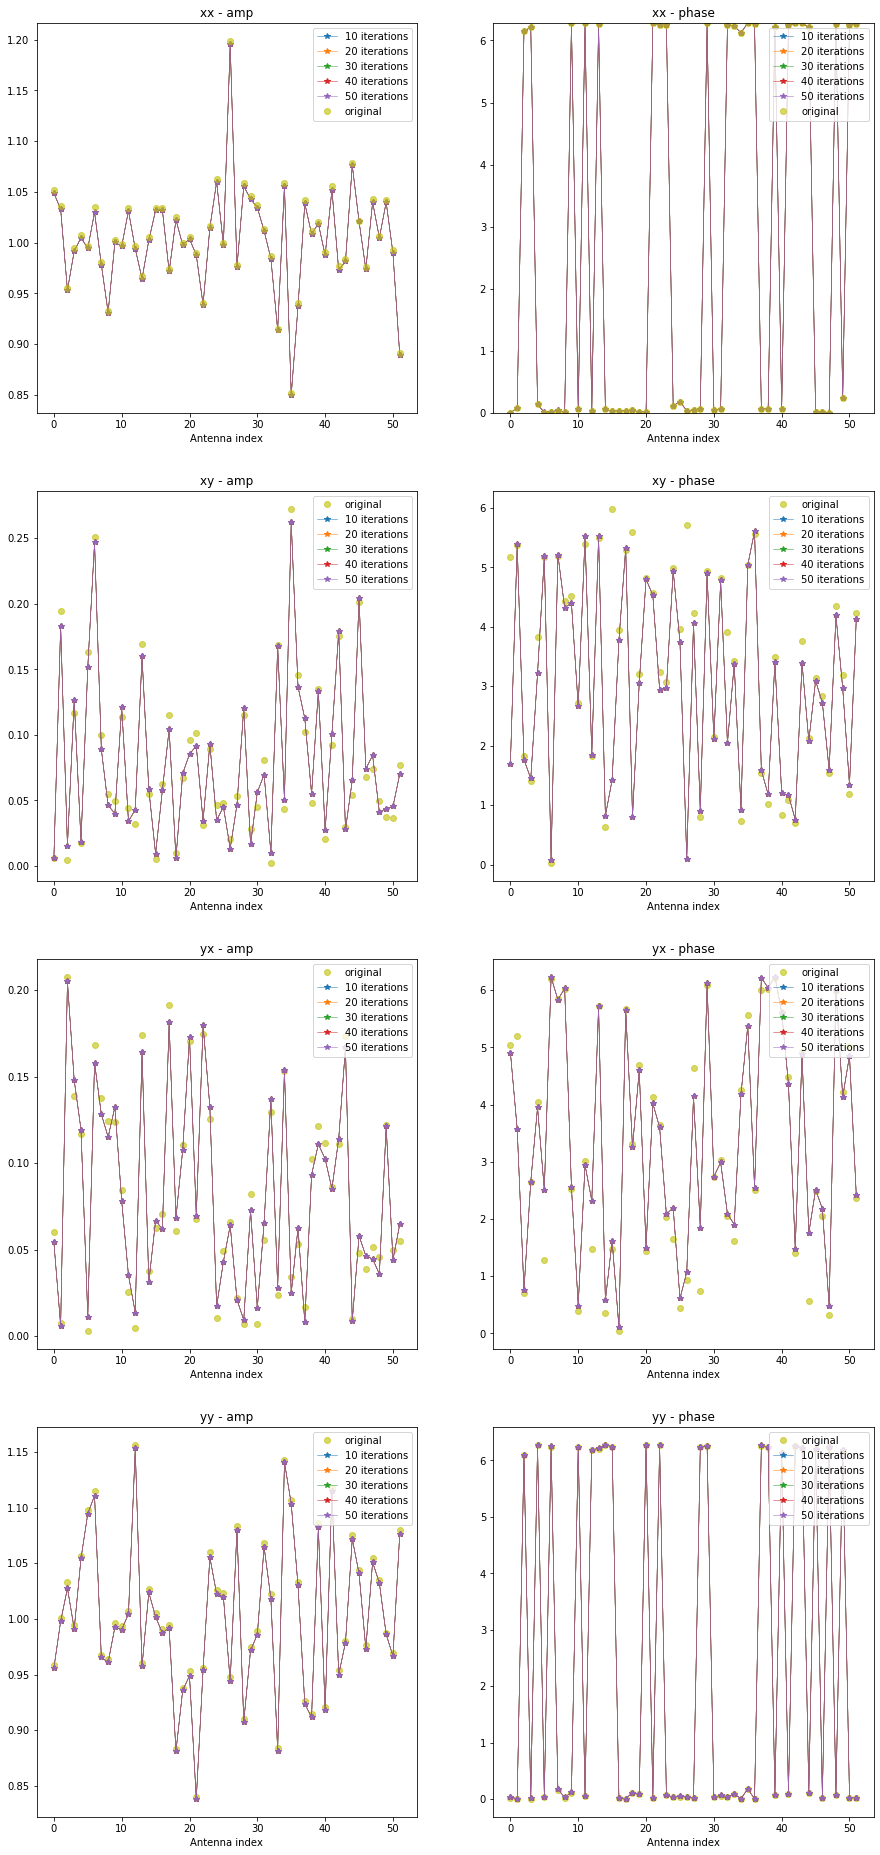

In [43]:
iterations = [10,20,30,40,50]
fig, axes = plt.subplots(figsize=(15,33), nrows=4, ncols=2)
ax = axes[0,0]
for (i,itetation) in enumerate(iterations):
    ax.plot(abs(gain_array_iterations[i][:,0,0]),'-*', label='{} iterations'.format(iterations[i]),lw=0.5)
ax.plot(abs(gain_array[:,300,0,0]),"o", label='original',lw=3, c='y',alpha=0.6)
ax.legend(loc='upper right')
ax.set_xlabel("Antenna index")
ax.set_title("xx - amp")

ax = axes[0,1]
for (i,itetation) in enumerate(iterations):
    angles_rec = np.angle(gain_array_iterations[i][:,0,0])
    angles_rec[np.where(angles_rec<0)] += 2*np.pi
    ax.plot(angles_rec,'-*', label='{} iterations'.format(iterations[i]), lw=0.5)
angles = np.angle(gain_array[:,300,0,0])
angles[np.where(angles<0)] += 2*np.pi
ax.plot(angles,'o',label='original',lw=3, c='y',alpha=0.6)
ax.set_ylim(0, np.pi*2)
ax.set_xlabel("Antenna index")
ax.set_title("xx - phase")
ax.legend(loc='upper right')

ax = axes[1,0]
ax.plot(abs(gain_array[:,300,0,1]),'o',label='original',lw=3, c='y',alpha=0.6)
for (i,itetation) in enumerate(iterations):
    ax.plot(abs(gain_array_iterations[i][:,0,1]),'-*', label='{} iterations'.format(iterations[i]),lw=0.5)
ax.set_xlabel("Antenna index")
ax.set_title("xy - amp")
ax.legend(loc='upper right')

ax = axes[1,1]
angles = np.angle(gain_array[:,300,0,1])
angles[np.where(angles<0)] += 2*np.pi
ax.plot(angles, "o", label='original', lw=3, c='y', alpha=0.6)
for (i,itetation) in enumerate(iterations):
    angles_rec = np.angle(gain_array_iterations[i][:,0,1])
    angles_rec[np.where(angles_rec<0)] += 2*np.pi
    ax.plot(angles_rec,'-*',label='{} iterations'.format(iterations[i]), lw=0.5)
ax.set_xlabel("Antenna index")
ax.set_title("xy - phase")
ax.legend(loc='upper right')

ax = axes[2,0]
ax.plot(abs(gain_array[:,300,1,0]),"o",label='original',lw=3, c='y',alpha=0.6)
for (i,itetation) in enumerate(iterations):
    ax.plot(abs(gain_array_iterations[i][:,1,0]),'-*', label='{} iterations'.format(iterations[i]),lw=0.5)
ax.set_xlabel("Antenna index")
ax.set_title("yx - amp")
ax.legend(loc='upper right')

ax = axes[2,1]
angles = np.angle(gain_array[:,300,1,0])
angles[np.where(angles<0)] += 2*np.pi
ax.plot(angles, "o", label='original',lw=3, c='y',alpha=0.6)
for (i,itetation) in enumerate(iterations):
    angles_rec = np.angle(gain_array_iterations[i][:,1,0])
    angles_rec[np.where(angles_rec<0)] += 2*np.pi
    ax.plot(angles_rec,'-*', label='{} iterations'.format(iterations[i]), lw=0.5)
ax.set_xlabel("Antenna index")
ax.set_title("yx - phase")
ax.legend(loc='upper right')

ax = axes[3,0]
ax.plot(abs(gain_array[:,300,1,1]),"o",label='original',lw=3, c='y',alpha=0.6)
for (i,itetation) in enumerate(iterations):
    ax.plot(abs(gain_array_iterations[i][:,1,1]),'-*', label='{} iterations'.format(iterations[i]),lw=0.5)
ax.set_xlabel("Antenna index")
ax.set_title("yy - amp")
ax.legend(loc='upper right')

ax = axes[3,1]
angles = np.angle(gain_array[:,300,1,1])
angles[np.where(angles<0)] += 2*np.pi
ax.plot(angles, "o", label='original',lw=3, c='y',alpha=0.6)
for (i,itetation) in enumerate(iterations):
    angles_rec = np.angle(gain_array_iterations[i][:,1,1])
    angles_rec[np.where(angles_rec<0)] += 2*np.pi
    ax.plot(angles_rec,'-*', label='{} iterations'.format(iterations[i]),lw=0.5)
ax.set_xlabel("Antenna index")
ax.set_title("yy - phase")
ax.legend(loc='upper right')

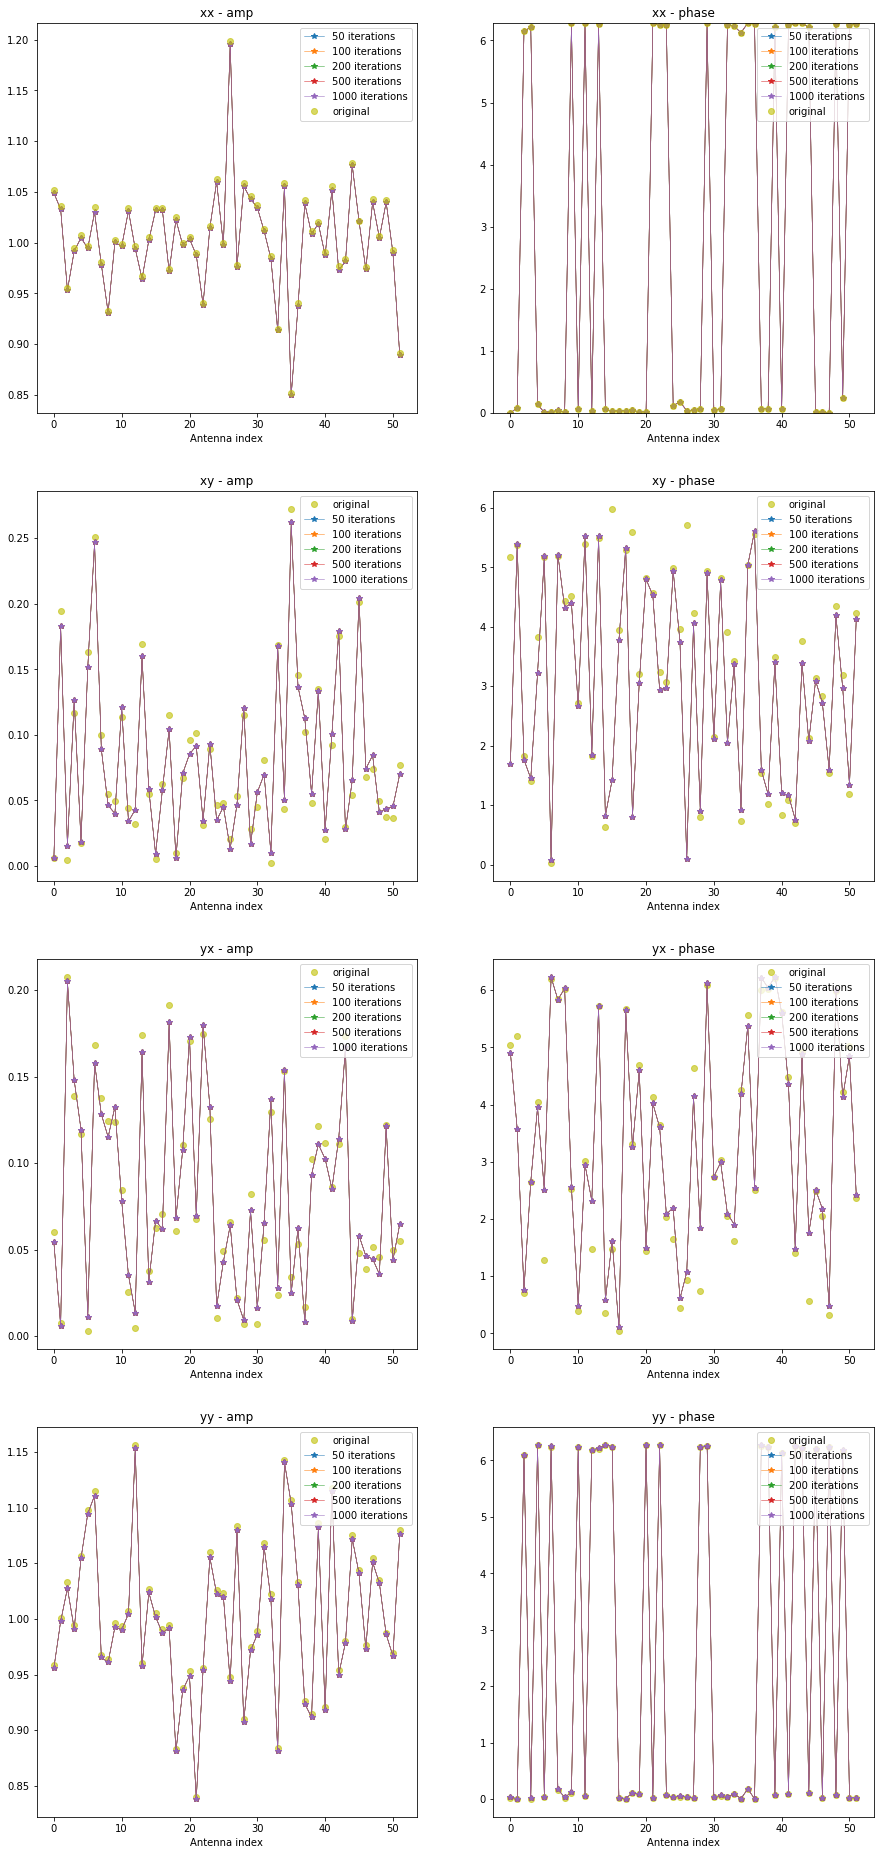

In [44]:
iterations = [50,100,200,500,1000]
fig, axes = plt.subplots(figsize=(15,33), nrows=4, ncols=2)
ax = axes[0,0]
for (i,itetation) in enumerate(iterations):
    ax.plot(abs(gain_array_iterations[i][:,0,0]),'-*', label='{} iterations'.format(iterations[i]),lw=0.5)
ax.plot(abs(gain_array[:,300,0,0]),"o", label='original',lw=3, c='y',alpha=0.6)
ax.legend(loc='upper right')
ax.set_xlabel("Antenna index")
ax.set_title("xx - amp")

ax = axes[0,1]
for (i,itetation) in enumerate(iterations):
    angles_rec = np.angle(gain_array_iterations[i][:,0,0])
    angles_rec[np.where(angles_rec<0)] += 2*np.pi
    ax.plot(angles_rec,'-*', label='{} iterations'.format(iterations[i]), lw=0.5)
angles = np.angle(gain_array[:,300,0,0])
angles[np.where(angles<0)] += 2*np.pi
ax.plot(angles,'o',label='original',lw=3, c='y',alpha=0.6)
ax.set_ylim(0, np.pi*2)
ax.set_xlabel("Antenna index")
ax.set_title("xx - phase")
ax.legend(loc='upper right')

ax = axes[1,0]
ax.plot(abs(gain_array[:,300,0,1]),'o',label='original',lw=3, c='y',alpha=0.6)
for (i,itetation) in enumerate(iterations):
    ax.plot(abs(gain_array_iterations[i][:,0,1]),'-*', label='{} iterations'.format(iterations[i]),lw=0.5)
ax.set_xlabel("Antenna index")
ax.set_title("xy - amp")
ax.legend(loc='upper right')

ax = axes[1,1]
angles = np.angle(gain_array[:,300,0,1])
angles[np.where(angles<0)] += 2*np.pi
ax.plot(angles, "o", label='original', lw=3, c='y', alpha=0.6)
for (i,itetation) in enumerate(iterations):
    angles_rec = np.angle(gain_array_iterations[i][:,0,1])
    angles_rec[np.where(angles_rec<0)] += 2*np.pi
    ax.plot(angles_rec,'-*',label='{} iterations'.format(iterations[i]), lw=0.5)
ax.set_xlabel("Antenna index")
ax.set_title("xy - phase")
ax.legend(loc='upper right')

ax = axes[2,0]
ax.plot(abs(gain_array[:,300,1,0]),"o",label='original',lw=3, c='y',alpha=0.6)
for (i,itetation) in enumerate(iterations):
    ax.plot(abs(gain_array_iterations[i][:,1,0]),'-*', label='{} iterations'.format(iterations[i]),lw=0.5)
ax.set_xlabel("Antenna index")
ax.set_title("yx - amp")
ax.legend(loc='upper right')

ax = axes[2,1]
angles = np.angle(gain_array[:,300,1,0])
angles[np.where(angles<0)] += 2*np.pi
ax.plot(angles, "o", label='original',lw=3, c='y',alpha=0.6)
for (i,itetation) in enumerate(iterations):
    angles_rec = np.angle(gain_array_iterations[i][:,1,0])
    angles_rec[np.where(angles_rec<0)] += 2*np.pi
    ax.plot(angles_rec,'-*', label='{} iterations'.format(iterations[i]), lw=0.5)
ax.set_xlabel("Antenna index")
ax.set_title("yx - phase")
ax.legend(loc='upper right')

ax = axes[3,0]
ax.plot(abs(gain_array[:,300,1,1]),"o",label='original',lw=3, c='y',alpha=0.6)
for (i,itetation) in enumerate(iterations):
    ax.plot(abs(gain_array_iterations[i][:,1,1]),'-*', label='{} iterations'.format(iterations[i]),lw=0.5)
ax.set_xlabel("Antenna index")
ax.set_title("yy - amp")
ax.legend(loc='upper right')

ax = axes[3,1]
angles = np.angle(gain_array[:,300,1,1])
angles[np.where(angles<0)] += 2*np.pi
ax.plot(angles, "o", label='original',lw=3, c='y',alpha=0.6)
for (i,itetation) in enumerate(iterations):
    angles_rec = np.angle(gain_array_iterations[i][:,1,1])
    angles_rec[np.where(angles_rec<0)] += 2*np.pi
    ax.plot(angles_rec,'-*', label='{} iterations'.format(iterations[i]),lw=0.5)
ax.set_xlabel("Antenna index")
ax.set_title("yy - phase")
ax.legend(loc='upper right')